In [20]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# Загрузка отфильтрованных данных из Excel в DataFrame

In [21]:
df = pd.read_excel("df_filtered.xlsx")

# Описание признаков и их типов

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77551 entries, 0 to 77550
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Расстояние до центра  77551 non-null  float64
 1   Кол-во комнат         77551 non-null  object 
 2   Общая площадь         77551 non-null  float64
 3   Этаж                  77551 non-null  int64  
 4   Ремонт                77551 non-null  object 
 5   Год постройки         77551 non-null  int64  
 6   Высота потолков       77551 non-null  float64
 7   Материал стен         77551 non-null  object 
 8   Цена                  77551 non-null  int64  
 9   Тип жилья             77551 non-null  object 
 10  Площадь кухни         77551 non-null  float64
 11  Станция               77551 non-null  object 
 12  Время                 77551 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 7.7+ MB


## Описание признаков в наборе данных

- **Расстояние до центра (float64)** – расстояние до центра города в километрах.
- **Кол-во комнат (object)** – количество комнат в квартире.
- **Общая площадь (float64)** – общая площадь квартиры в квадратных метрах.
- **Этаж (int64)** – этаж, на котором расположена квартира.
- **Ремонт (object)** – состояние ремонта в квартире (например, без ремонта, евро).
- **Год постройки (int64)** – год постройки здания.
- **Высота потолков (float64)** – высота потолков в квартире в метрах.
- **Материал стен (object)** – материал, из которого построено здание (например, монолит).
- **Цена (int64)** – стоимость объекта недвижимости.
- **Тип жилья (object)** – тип объекта недвижимости (например, апартаменты).
- **Площадь кухни (float64)** – площадь кухни в квартире.
- **Станция (object)** – название ближайшей станции метро.
- **Время (int64)** – время до ближайшей станции метро (в минутах).


In [ ]:
df.head()

,Расстояние до центра,Кол-во комнат,Общая площадь,Этаж,Ремонт,Год постройки,Высота потолков,Материал стен,Цена,Тип жилья,Площадь кухни,Станция,Время
0,7.9,0,23.0,20,Нужен ремонт,2024,3.00,монолит,11000000,квартира,10.9,Нагатинская,19
1,19.4,0,22.0,19,Без отделки,2025,2.73,монолит,8526738,квартира,10.9,Солнцево,8
2,9.4,0,17.0,1,Чистовая отделка,0,3.00,кирпич,5950000,квартира,10.9,Красный Балтиец,7
3,19.3,0,22.0,20,Без отделки,2025,2.73,монолит,8422392,квартира,10.9,Солнцево,8
4,0.0,0,19.2,1,Без отделки,0,3.30,кирпич,11520000,апартаменты,10.9,Смоленская,9


# Основные статистики

In [ ]:
df.describe()

,Расстояние до центра,Общая площадь,Этаж,Год постройки,Высота потолков,Цена,Площадь кухни,Время
count,77551.000000,77551.000000,77551.00000,77551.000000,77551.000000,7.755100e+04,77551.000000,77551.000000
mean,13.548776,52.439449,10.90748,1265.328274,3.100807,1.881114e+07,11.705421,19.180642
std,6.659677,22.035774,8.92632,979.977703,7.798802,1.050069e+07,5.175322,12.467975
min,0.000000,8.000000,0.00000,0.000000,1.550000,1.180000e+04,0.500000,1.000000
25%,8.800000,36.600000,4.00000,0.000000,2.700000,1.130000e+07,8.500000,11.000000
50%,12.300000,48.800000,9.00000,2023.000000,2.850000,1.553576e+07,10.900000,16.000000
75%,17.200000,64.500000,15.00000,2026.000000,2.980000,2.300000e+07,13.700000,24.000000
max,30.000000,267.400000,80.00000,2028.000000,390.000000,5.559462e+07,78.000000,82.000000


In [ ]:
df.describe(include=["object"])

,Кол-во комнат,Ремонт,Материал стен,Тип жилья,Станция
count,77551,77551,77551,77551,77551
unique,7,8,6,2,285
top,2,Без отделки,монолит,квартира,Коммунарка
freq,26220,38501,48353,71320,3473


# Валидация и очистка данных от аномалий

In [23]:
# Исключаем слишком большие квартиры (> 200 кв.м)
df_cleaned = df[df['Общая площадь'] <= 200]

# Ограничиваем этажность (максимум 50 этажей)
df_cleaned = df_cleaned[df_cleaned['Этаж'] <= 50]

# Убираем здания старше 100 лет
current_year = pd.Timestamp.now().year
df_cleaned = df_cleaned[df_cleaned['Год постройки'] >= (current_year - 100)]

# Ограничиваем высоту потолков (не более 5 м)
df_cleaned = df_cleaned[df_cleaned['Высота потолков'] <= 5]

# Исключаем элитные квартиры (> 100 млн руб.)
df_cleaned = df_cleaned[df_cleaned['Цена'] <= 100000000]

# Убираем слишком большие кухни (> 50 кв.м)
df_cleaned = df_cleaned[df_cleaned['Площадь кухни'] <= 50]

# Изучение поведения каждого признака

In [ ]:
def plot_feature_distributions(data, features):
    for feature in features:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        sns.histplot(data[feature], bins=30, kde=True, ax=axes[0], color='skyblue', edgecolor='black')
        axes[0].set_title(f"Распределение '{feature}'", fontsize=14)
        axes[0].set_xlabel(feature, fontsize=12)
        axes[0].set_ylabel('Частота', fontsize=12)
        axes[0].grid(visible=True, linestyle='--', alpha=0.6)

        sns.boxplot(y=data[feature], ax=axes[1], color='lightgreen', width=0.5)
        axes[1].set_title(f"Boxplot '{feature}'", fontsize=14)
        axes[1].set_ylabel(feature, fontsize=12)
        axes[1].grid(visible=True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

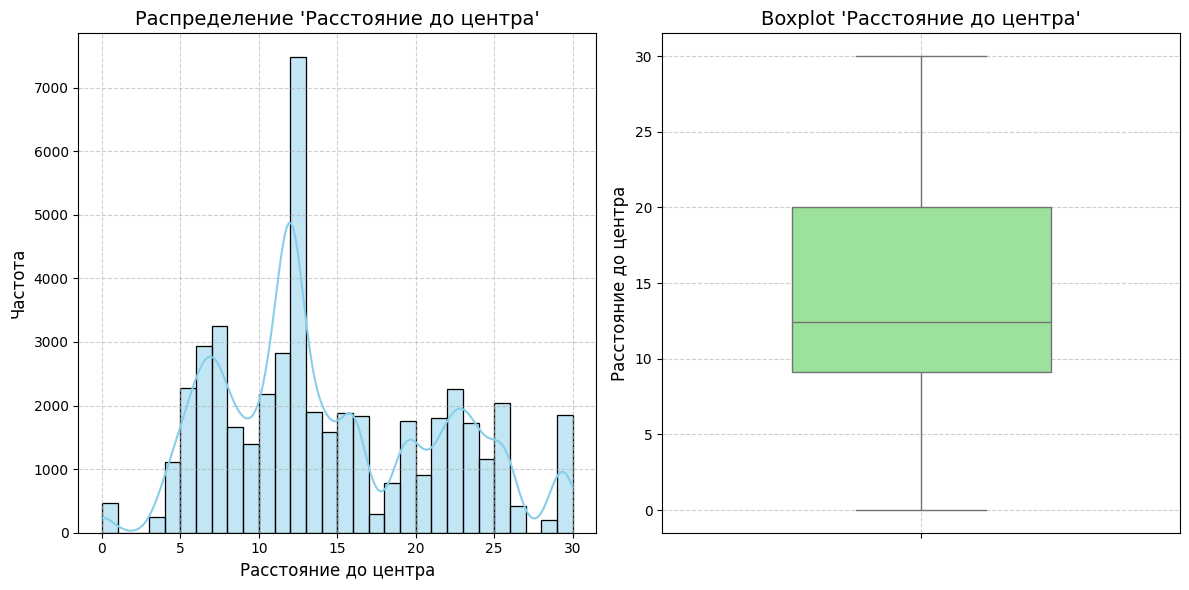

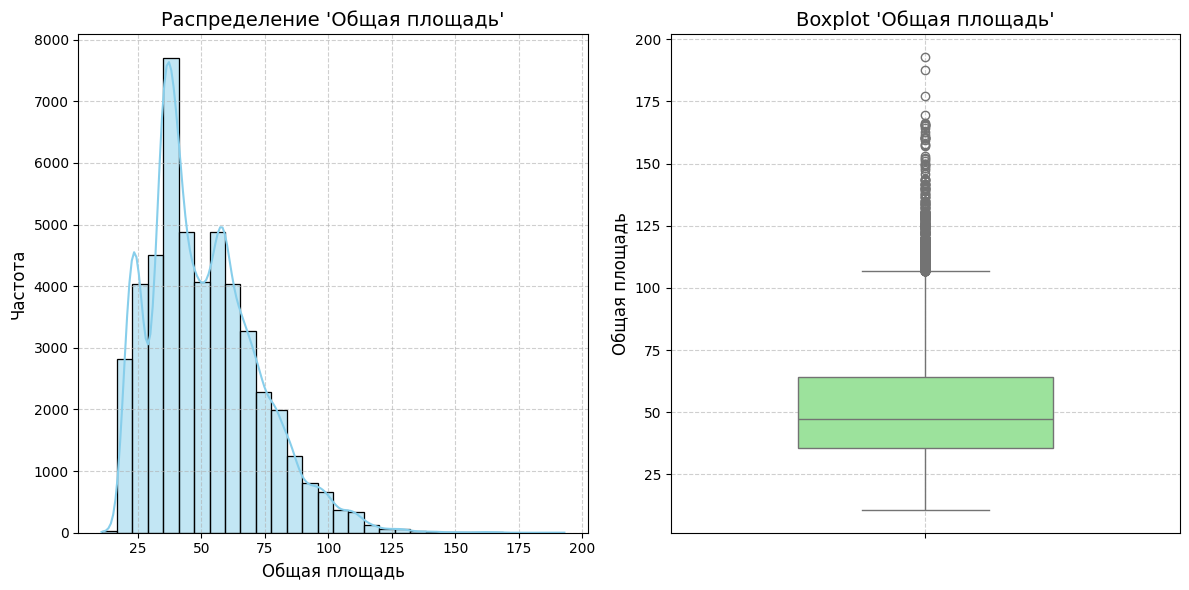

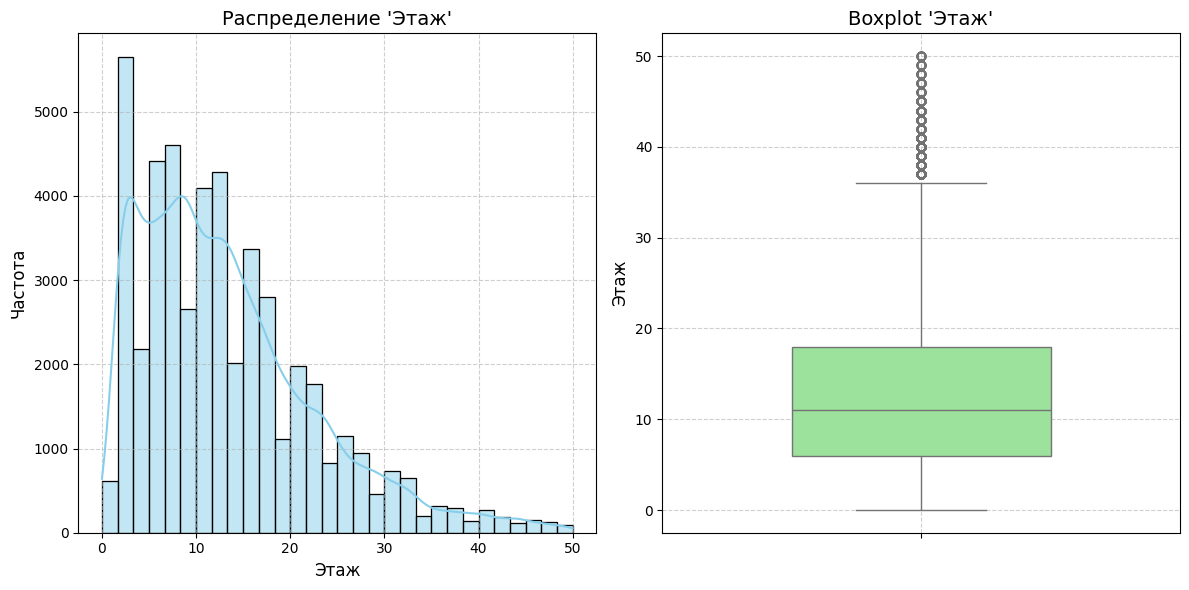

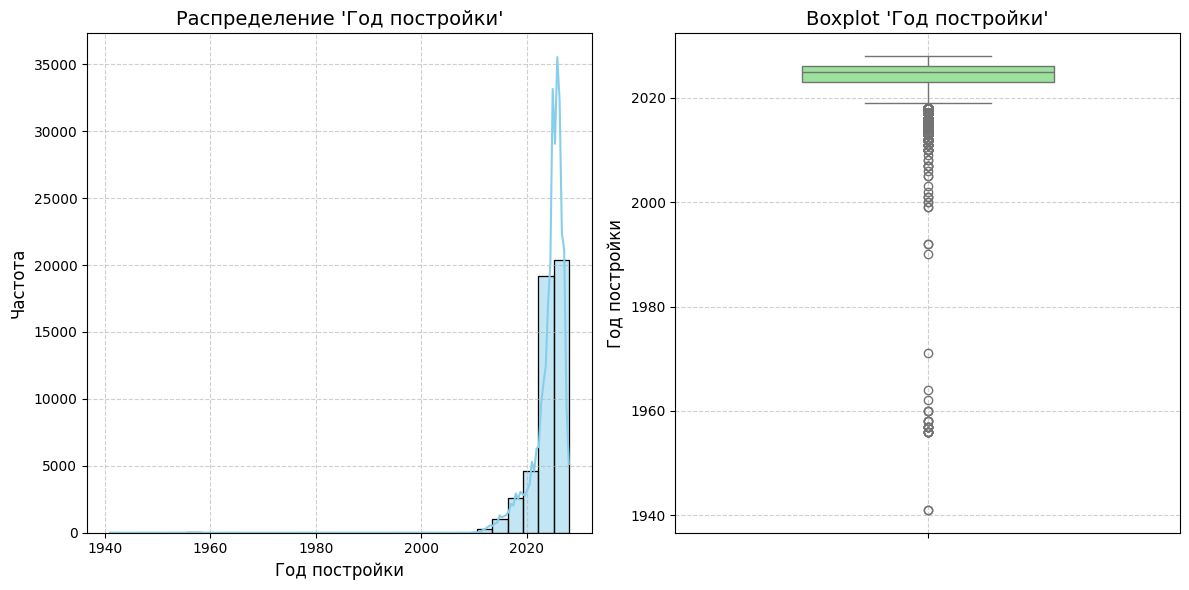

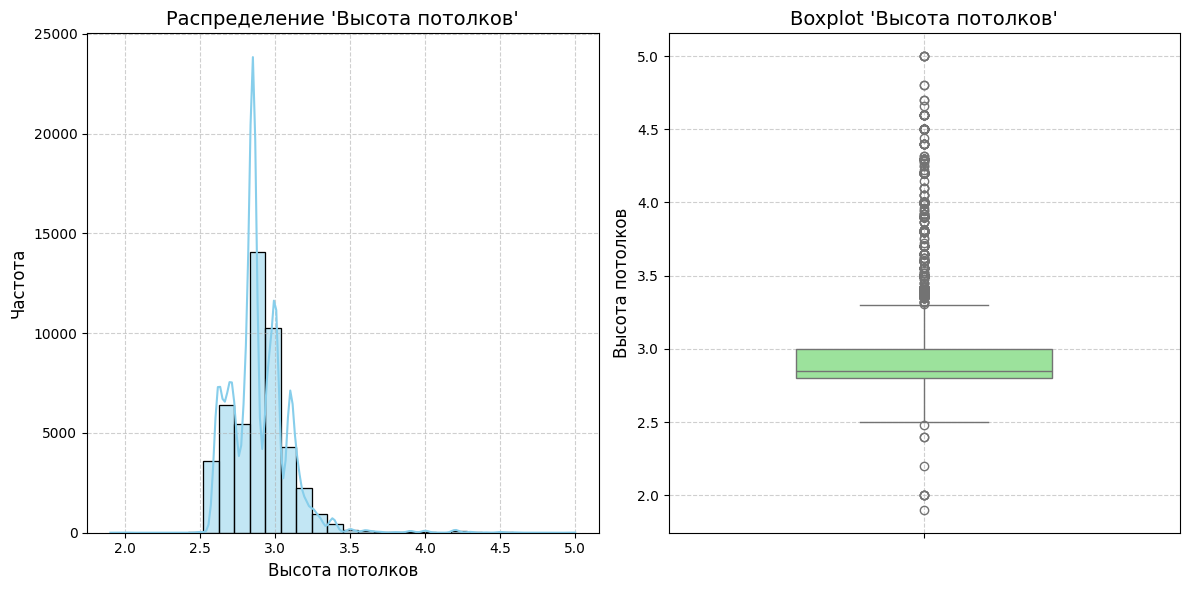

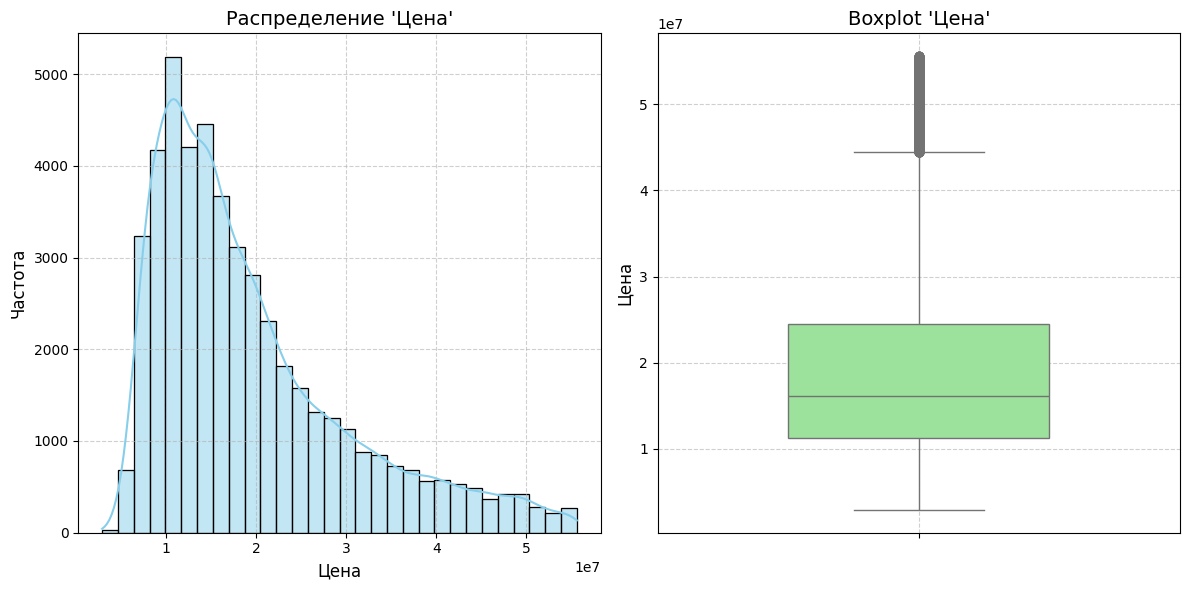

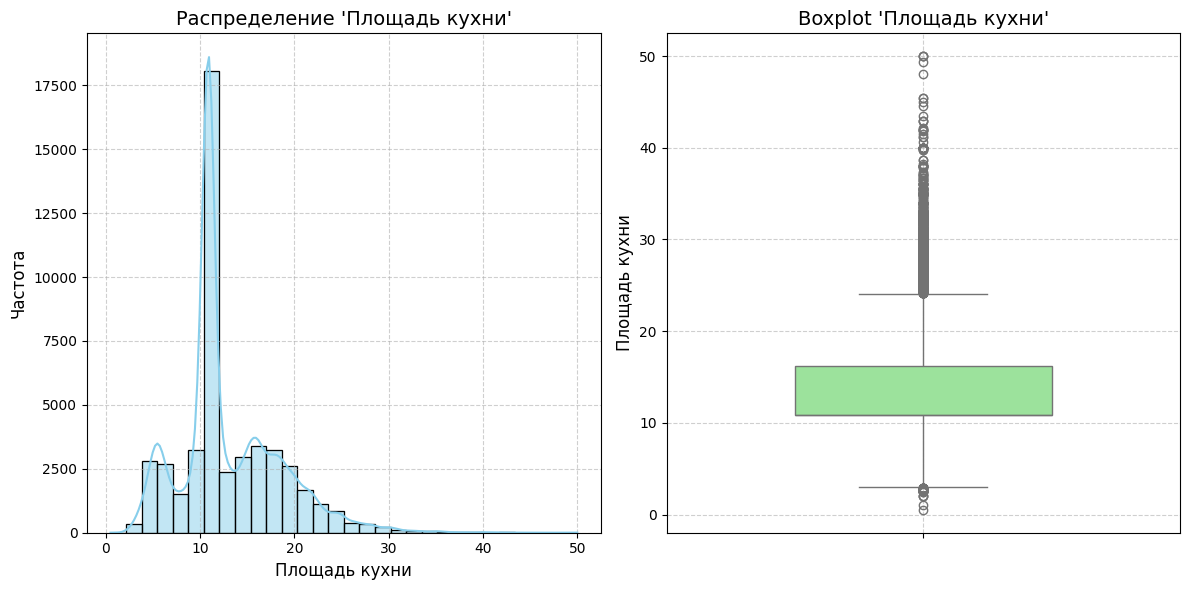

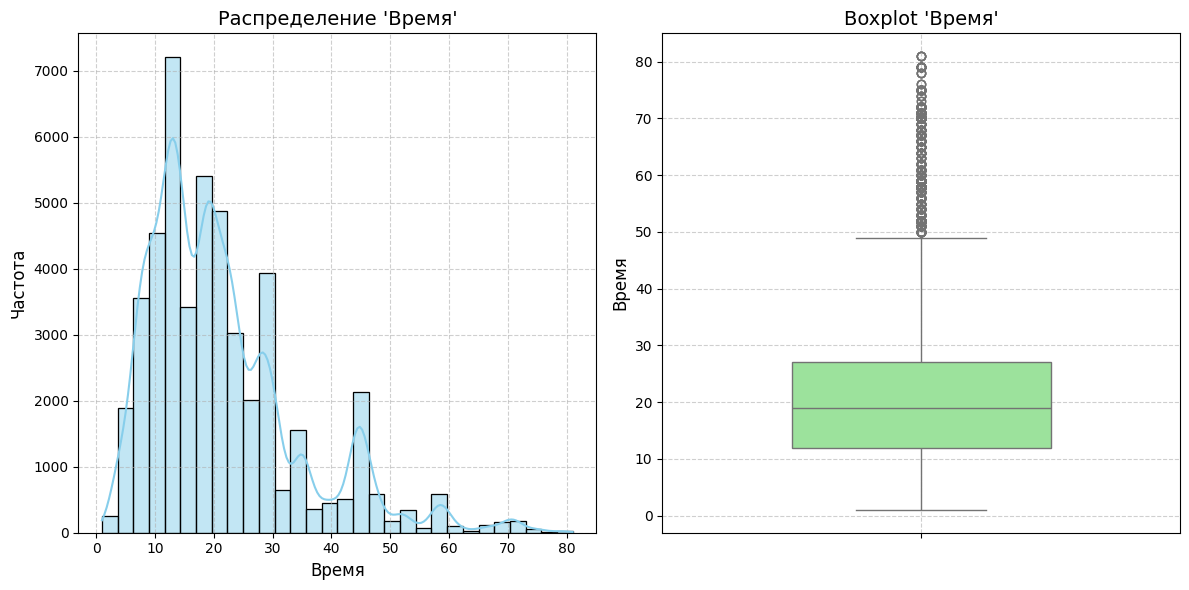

In [ ]:
numerical_features = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
plot_feature_distributions(df_cleaned, numerical_features)

# Подготовка данных для обучения: разделение на признаки и целевую переменную

In [24]:
X = df_cleaned.drop(columns=['Цена'])
y = df_cleaned['Цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Кодирование категориальных признаков с помощью One-Hot Encoding

In [25]:
categorical_features = X_train.select_dtypes(include=['object']).columns

X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

X_test = X_test[X_train.columns]

# Обучение модели дерева решений


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"R^2 score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

R^2 score: 0.9203
RMSE: 3100371.7021
MAPE: 6.09%


## Анализ структуры дерева решений


In [ ]:
tree_depth = decision_tree.get_depth()
num_leaves = decision_tree.get_n_leaves()

print(f"Глубина дерева: {tree_depth}")
print(f"Количество листьев: {num_leaves}")

Глубина дерева: 48
Количество листьев: 34963


## Анализ важности признаков в модели дерева решений

In [ ]:
feature_importances_dt = pd.DataFrame({'Признак': X_train.columns, 'Важность': decision_tree.feature_importances_}).sort_values(by='Важность', ascending=False)
feature_importances_dt.head()

,Признак,Важность
1,Общая площадь,0.544767
0,Расстояние до центра,0.242990
6,Время,0.058292
4,Высота потолков,0.051525
2,Этаж,0.010795


## Подбор оптимальных гиперпараметров для дерева решений с помощью кросс-валидации


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid,
                           scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")

Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


## Оценка качества предсказаний оптимизированной модели


In [ ]:
y_pred_optimized = grid_search.best_estimator_.predict(X_test)

optimized_r2 = r2_score(y_test, y_pred_optimized)
optimized_rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
optimized_mape = np.mean(np.abs((y_test - y_pred_optimized) / y_test)) * 100

print(f"R^2 score: {optimized_r2:.4f}")
print(f"RMSE: {optimized_rmse:.4f}")
print(f"MAPE: {optimized_mape:.2f}%")

R^2 score: 0.9261
RMSE: 2984693.2473
MAPE: 6.35%


## Сравнение метрик качества начальной и оптимизированной моделей


In [ ]:
comparison_df = pd.DataFrame({
    "Метрика": ["R^2 score", "RMSE", "MAPE"],
    "Начальная модель": [r2, rmse, mape],
    "Оптимизированная модель": [optimized_r2, optimized_rmse, optimized_mape]
})

print(comparison_df.to_string(index=False))

  Метрика  Начальная модель  Оптимизированная модель
R^2 score      9.202632e-01             9.261024e-01
     RMSE      3.100372e+06             2.984693e+06
     MAPE      6.094208e+00             6.354678e+00


### **Выводы по дереву решений**

1. **R² улучшился** (с 0.9203 до 0.9261) — модель стала точнее.  
2. **RMSE снизился** (с 3 100 372 до 2 984 693) — ошибки уменьшились.  
3. **MAPE вырос** (с 6.09% до 6.35%) — модель стала хуже предсказывать для некоторых объектов.  
4. **Гиперпараметры:**  
   - `max_depth=None` — дерево не ограничено в глубине.  
   - `min_samples_leaf=1` — возможны переобученные узлы.  
   - `min_samples_split=10` — снижает избыточное разбиение.  

### **Вывод:**  
Оптимизация улучшила R² и RMSE, но увеличила MAPE. Возможно, стоит ограничить глубину дерева (`max_depth=15-20`) или увеличить `min_samples_leaf` (до 2-5) для лучшего баланса.

# Обучение модели случайного леса

In [26]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(random_state=42, n_estimators=100)
random_forest.fit(X_train, y_train)

y_pred_forest = random_forest.predict(X_test)

r2_forest = r2_score(y_test, y_pred_forest)
rmse_forest = np.sqrt(mean_squared_error(y_test, y_pred_forest))
mape_forest = np.mean(np.abs((y_test - y_pred_forest) / y_test)) * 100

print(f"R^2 score: {r2_forest:.4f}")
print(f"RMSE: {rmse_forest:.4f}")
print(f"MAPE: {mape_forest:.2f}%")

R^2 score: 0.9603
RMSE: 2188182.4809
MAPE: 4.76%


## Анализ важности признаков в модели случайного леса

In [ ]:
feature_importances_rf = pd.DataFrame({'Признак': X_train.columns, 'Важность': random_forest.feature_importances_}).sort_values(by='Важность', ascending=False)
feature_importances_rf.head()

,Признак,Важность
1,Общая площадь,0.541088
0,Расстояние до центра,0.243138
6,Время,0.055796
4,Высота потолков,0.054013
3,Год постройки,0.011912


## Подбор оптимальных гиперпараметров случайного леса с использованием RandomizedSearchCV


In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), param_distributions=param_dist,
    scoring='r2', cv=5, n_iter=20, n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)

print(f"Лучшие параметры: {random_search.best_params_}")

Лучшие параметры: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


## Оценка качества предсказаний оптимизированной модели

In [28]:
best_forest = random_search.best_estimator_
y_pred_optimized_forest = best_forest.predict(X_test)

optimized_r2_forest = r2_score(y_test, y_pred_optimized_forest)
optimized_rmse_forest = np.sqrt(mean_squared_error(y_test, y_pred_optimized_forest))
optimized_mape_forest = np.mean(np.abs((y_test - y_pred_optimized_forest) / y_test)) * 100

print(f"R^2 score: {optimized_r2_forest:.4f}")
print(f"RMSE: {optimized_rmse_forest:.4f}")
print(f"MAPE: {optimized_mape_forest:.2f}%")

R^2 score: 0.9545
RMSE: 2341609.6685
MAPE: 5.50%


## Сравнение метрик качества начальной и оптимизированной моделей


In [29]:
comparison_df = pd.DataFrame({
    "Метрика": ["R^2 score", "RMSE", "MAPE"],
    "Начальная модель": [r2_forest, rmse_forest, mape_forest],
    "Оптимизированная модель": [optimized_r2_forest, optimized_rmse_forest, optimized_mape_forest]
})

print(comparison_df.to_string(index=False))

  Метрика  Начальная модель  Оптимизированная модель
R^2 score      9.602810e-01             9.545158e-01
     RMSE      2.188182e+06             2.341610e+06
     MAPE      4.756140e+00             5.495961e+00


### **Выводы по случайному лесу**

1. **R² ухудшился** (с 0.9603 до 0.9545) — модель стала менее точной.  
2. **RMSE вырос** (с 2 188 182 до 2 341 610) — ошибки увеличились.  
3. **MAPE ухудшился** (с 4.76% до 5.50%) — выше относительная ошибка.  
4. **Гиперпараметры:**  
   - `n_estimators=50` — меньше деревьев, быстрее, но менее устойчиво.  
   - `max_depth=None` — неограниченная глубина, возможно, переобучение.  
   - `min_samples_leaf=1` — делает модель гибкой, но может давать шум.  
   - `min_samples_split=2` — дерево разветвляется чаще.  
   - `max_features='sqrt'` — ускоряет обучение, но снижает качество предсказаний.  

### **Вывод:**  
Оптимизация ухудшила все метрики. Возможно, модель переобучилась или, наоборот, стала слишком простой. Стоит увеличить `n_estimators` (до 100-200) и `min_samples_leaf` (до 2-5) для лучшего баланса.